# Métricas en clasificación

Special thanks to [Felipe Alonso Atienza](www.linkedin.com/in/felipe-alonso-atienza)

En este Notebook vamos analizar distintas métricas y algoritmos sobre un problema de clasificación desbalanceado. 

## Contenidos

1. Análisis exploratorio
2. Métricas clasificación
3. Comparación clasificadores

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [185]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [186]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

# 1. Análisis exploratorio

Vamos a trabajar con datos de fuga de una compañía telefónica. El objetivo es predecir cuándo los clientes van a abandonar la compañía.

<div class = "alert alert-success">
**EJERCICIO**: Cargue los datos *churn.csv* y realice un primer análisis de los datos cargados
</div>

<div class = "alert alert-success">
**EJERCICIO**: Este problema está desbalanceado, calcule el ratio de desbalanceo
</div>

In [187]:
data = pd.read_csv('census.csv',sep=',',decimal='.')
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [188]:
filas,columnas=data.shape
print("Filas=",filas,", Columnas=",columnas)

Filas= 45222 , Columnas= 14


In [189]:
ejercicio1_type=data.dtypes.to_frame(name='tipo')
print("Tipos de variables:\n",pd.concat([ejercicio1_type,data.astype('object').describe().transpose()], axis=1))

Tipos de variables:
                     tipo  count unique                  top   freq
age                int64  45222     74                   36   1283
workclass         object  45222      7              Private  33307
education_level   object  45222     16              HS-grad  14783
education-num    float64  45222     16                    9  14783
marital-status    object  45222      7   Married-civ-spouse  21055
occupation        object  45222     14         Craft-repair   6020
relationship      object  45222      6              Husband  18666
race              object  45222      5                White  38903
sex               object  45222      2                 Male  30527
capital-gain     float64  45222    121                    0  41432
capital-loss     float64  45222     97                    0  43082
hours-per-week   float64  45222     96                   40  21358
native-country    object  45222     41        United-States  41292
income            object  45222      2   

In [190]:
print(data.describe())

                age  education-num  capital-gain  capital-loss  hours-per-week
count  45222.000000   45222.000000  45222.000000  45222.000000    45222.000000
mean      38.547941      10.118460   1101.430344     88.595418       40.938017
std       13.217870       2.552881   7506.430084    404.956092       12.007508
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       47.000000      13.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000


In [245]:
#ratio desbalanceo
data['income'].value_counts()/data.shape[0] #la muestra está desbalanceada

0    0.752156
1    0.247844
Name: income, dtype: float64

In [192]:
print("No missing data:\n",data.isnull().sum())

No missing data:
 age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


In [193]:
#Variables categóricas y numéricas
var_cat=['workclass','education_level','marital-status','occupation','relationship','race','sex','native-country','income']
var_num=['age','education-num','capital-gain','capital-loss','hours-per-week']

In [194]:
#Eliminate trailing spaces in categorical variables
for col in var_cat:
    data[col]=data[col].map(lambda x: x.strip())


In [195]:
###Get all categories   
#dichotomize income to understand better the categories
data['income']=np.where(data['income'].isin(['>50K']), 1, 0)
for col in var_cat:
    results=data.groupby(col).agg({'income':['count','sum']}).sort_values([('income', 'count')],ascending=False)
    results.columns=results.columns.droplevel(0)
    results.columns=['count','higher>50K']
    print("Unique",col,"\n",results)

###No categories "unknown"

Unique workclass 
                   count  higher>50K
workclass                          
Private           33307        7251
Self-emp-not-inc   3796        1059
Local-gov          3100         915
State-gov          1946         520
Self-emp-inc       1646         912
Federal-gov        1406         549
Without-pay          21           2
Unique education_level 
                  count  higher>50K
education_level                   
HS-grad          14783        2416
Some-college      9899        1990
Bachelors         7570        3178
Masters           2514        1393
Assoc-voc         1959         504
11th              1619          89
Assoc-acdm        1507         398
10th              1223          82
7th-8th            823          55
Prof-school        785         592
9th                676          38
12th               577          43
Doctorate          544         399
5th-6th            449          22
1st-4th            222           8
Preschool           72           1
Un

In [196]:
# In workclass, Self-emp-not-inc and without pay contain records with salary >50k, probably correspond 
# to previous year
# or the data was not correctly recorded
# as I can no comment with responsible/business I will group both categories in one "Not income"
data['workclass']=np.where(data['workclass'].isin(['Self-emp-not-inc','Without-pay']), 'Not income', data['workclass'])

#education level: https://en.wikipedia.org/wiki/Education_in_the_United_States
#Education level below 8th means no elementary education
data['education_level']=np.where(data['education_level'].isin(['Preschool','1st-4th','5th-6th','7th-8th'])
                                 ,'No_Elementary', data['education_level'])
#Education until 12th grade means no grad fromn HS
data['education_level']=np.where(data['education_level'].isin(['9th','10th','11th','12th'])
                                 ,'HS_no_grad', data['education_level'])
#Assoc level education
data['education_level']=np.where(data['education_level'].isin(['Assoc-voc','Assoc-acdm'])
                                 ,'Assoc', data['education_level'])
#marital status: http://www.unmarried.org/government-terminology/
#married
data['marital-status']=np.where(data['marital-status'].isin(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'])
                                 ,'married', data['marital-status'])
#married before as income higher>50K round 10% in the 3 categories
data['marital-status']=np.where(data['marital-status'].isin(['Divorced','Separated','Widowed'])
                                 ,'married_before', data['marital-status'])
#native-country: I classify them as United States, g20, emerging and other countries.
data['native-country']=np.where(data['native-country'].isin(['United-States'])
                                 ,'United-States', data['native-country'])
data['native-country']=np.where(data['native-country'].isin(['Argentina', 'Australia', 'Brazil', 'Canada', 'China', 'France', 'Germany', 'India', 'Indonesia', 'Italy', 'Japan', 'Mexico', 'Russia', 'Saudi Arabia', 'South Africa', 'South Korea', 'Turkey', 'United Kingdom', 'United States', 'England', 'Ireland', 'Scotland'])
                                 ,'G20', data['native-country'])
data['native-country']=np.where(data['native-country'].isin(['China', 'India', 'Indonesia', 'Turkey', 'Lebanon', 'Malaysia', 'Pakistan', 'Philippines', 'Thailand', 'Vietnam', 'Egypt', 'Kenya', 'Morocco', 'Senegal', 'South Africa', 'Tunisia', 'Bulgaria', 'Hungary', 'Poland', 'Romania', 'Russia', 'Ukraine', 'Mexico', 'Dominican Republic', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Uruguay', 'Venezuela'])
                                 ,'Emerging_countries', data['native-country'])                           
data['native-country']=np.where(~data['native-country'].isin(['G20','Emerging_countries','United-States'])
                                 ,'Other_countries', data['native-country'])   

#Get all categories   
for col in var_cat:
    results=data.groupby(col).agg({'income':['count','sum']}).sort_values([('income', 'count')],ascending=False)
    results.columns=results.columns.droplevel(0)
    results.columns=['count','higher>50K']
    print("Unique",col,"\n",results)

Unique workclass 
               count  higher>50K
workclass                      
Private       33307        7251
Not income     3817        1061
Local-gov      3100         915
State-gov      1946         520
Self-emp-inc   1646         912
Federal-gov    1406         549
Unique education_level 
                  count  higher>50K
education_level                   
HS-grad          14783        2416
Some-college      9899        1990
Bachelors         7570        3178
HS_no_grad        4095         252
Assoc             3466         902
Masters           2514        1393
No_Elementary     1566          86
Prof-school        785         592
Doctorate          544         399
Unique marital-status 
                 count  higher>50K
marital-status                   
married         21639        9632
Never-married   14598         701
married_before   8985         875
Unique occupation 
                    count  higher>50K
occupation                          
Craft-repair        6020   

##  1.1 preprocesamiento de variables

Si escribimos *data.dtypes* nos indica el tipo de las variables de nuestro dataframe. Vemos que tenemos variables categóricas que tenemos que codificar. 

<div class = "alert alert-success">
**EJERCICIO**: Elimine la variable *phone number* y codifique las variables categóricas.
</div>

In [197]:
# no variables to drop at this point
#data = data.drop('',axis=1)

In [198]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
var_cat_aux=list(var_cat)
var_cat_aux.remove('income')
for col in var_cat_aux:
    data[col] = le.fit_transform(data[col])

#Get all categories   
for col in var_cat:
    results=data.groupby(col).agg({'income':['count','sum']}).sort_values([('income', 'count')],ascending=False)
    results.columns=results.columns.droplevel(0)
    results.columns=['count','higher>50K']
    print("Unique",results)


Unique            count  higher>50K
workclass                   
3          33307        7251
2           3817        1061
1           3100         915
5           1946         520
4           1646         912
0           1406         549
Unique                  count  higher>50K
education_level                   
3                14783        2416
8                 9899        1990
1                 7570        3178
4                 4095         252
0                 3466         902
5                 2514        1393
6                 1566          86
7                  785         592
2                  544         399
Unique                 count  higher>50K
marital-status                   
1               21639        9632
0               14598         701
2                8985         875
Unique             count  higher>50K
occupation                   
2            6020        1355
9            6008        2704
3            5984        2867
0            5540         756
11   

<div class = "alert alert-success">
**EJERCICIO**: Represente el histograma de las variable con distintos colores para cada clase.
</div>

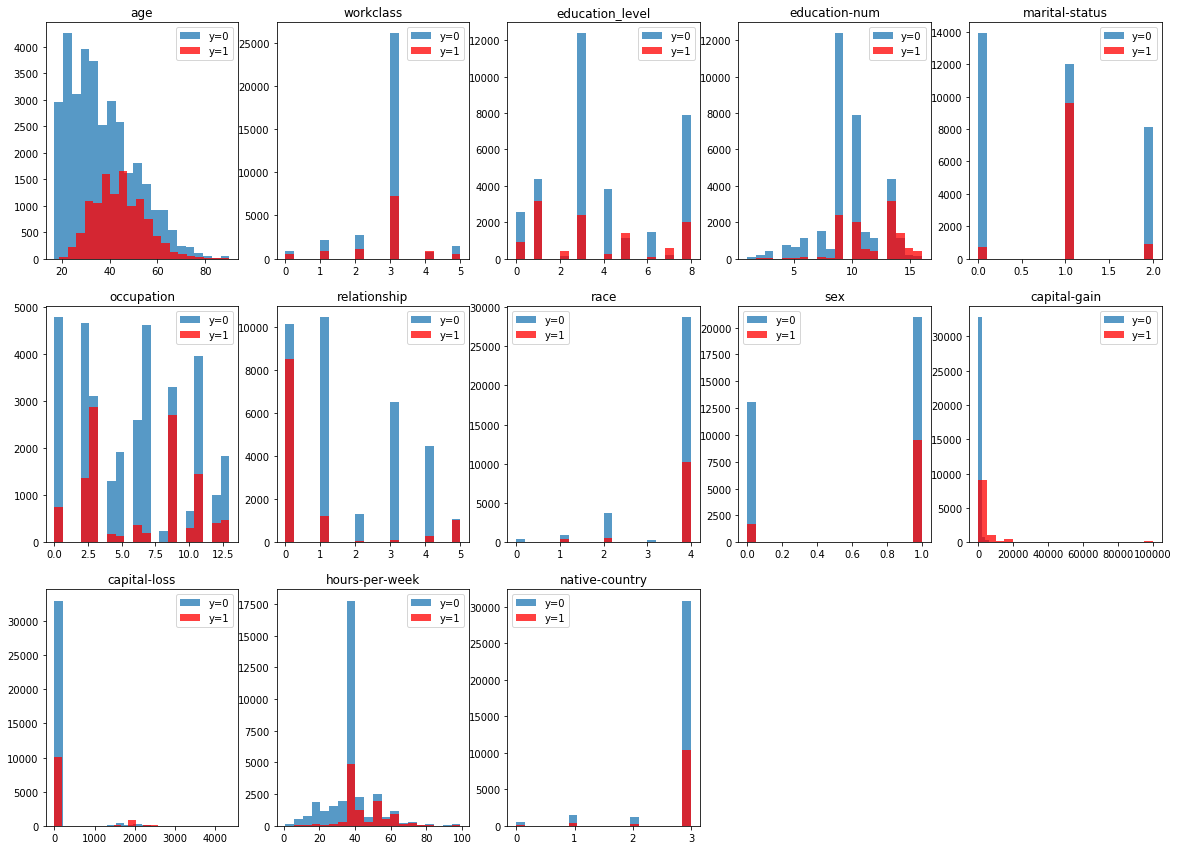

In [199]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,20))

idx_0 =  data['income'] == 0
idx_1 =  data['income'] == 1

# your code here

for i,feature in enumerate(data.columns.drop(['income'])):
    plt.subplot(4,5,i+1)   
    plt.hist(data.ix[idx_0,feature],normed=0, bins = 20, alpha=0.75,label='y=0')
    plt.hist(data.ix[idx_1,feature],normed=0, bins = 20, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

## Se puede apreciar que hay solapamiento en todas las variables por lo que es un problema 
## complejo de clasificar

## 1.2 Correlación entre variables

<div class = "alert alert-success">
**EJERCICIO**: Represente el mapa de correlación entre variables
</div>

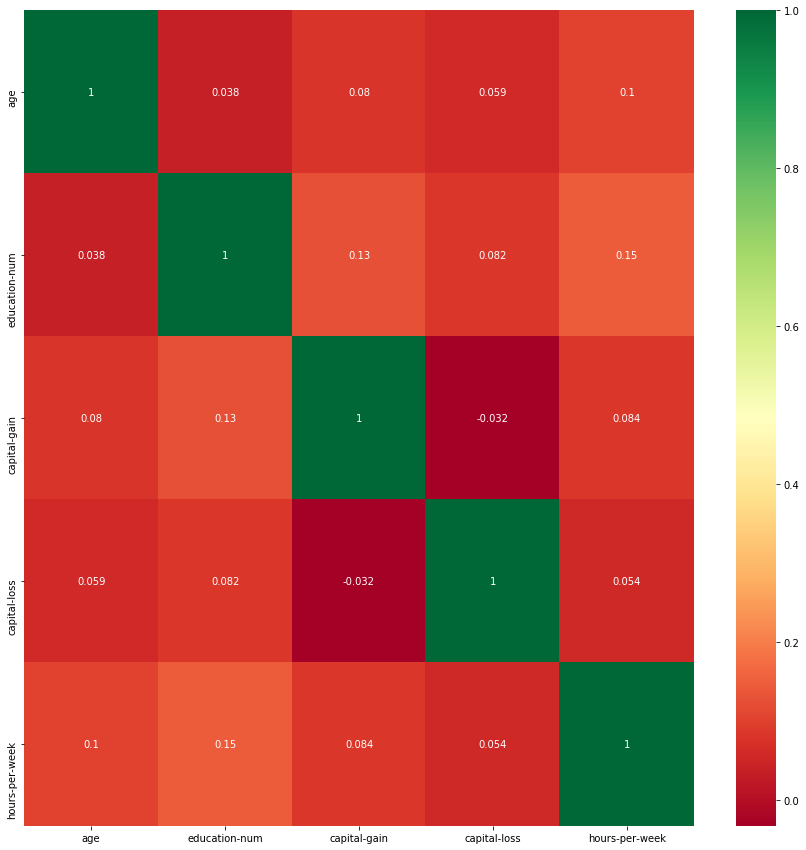

In [210]:
# plot the heatmap
top_corr_features = data.columns.drop(list(var_cat))
plt.figure(figsize=(15,15))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

En clasificación, variables correlacionadas no afectan al proceso de clasificación. Sin embargo, dada la correlación extrema y con el objetivo de eliminar variables poco informativas, podemos eliminar algunas columnas.

In [229]:
#Manual one hot encoder for variables: workclass, education_level, marital_status, occupation, relationship, race, native_country
#I do it after analyzing histograms and as previous step to performing classification algorithms
data=pd.get_dummies(data, columns=['workclass','education_level', 'marital-status', 'occupation', 'relationship', 'race', 'native-country'],
                           prefix={'workclass':'workclass','education_level':'edulev', 'marital-status':'marital_-status', 'occupation':'ocupation', 'relationship':'relationship',
                                   'race':'race', 'native-country':'native-country'},
                           drop_first =True)
print(data.head())

   age  education-num  sex  capital-gain  capital-loss  hours-per-week  \
0   39           13.0    1        2174.0           0.0            40.0   
1   50           13.0    1           0.0           0.0            13.0   
2   38            9.0    1           0.0           0.0            40.0   
3   53            7.0    1           0.0           0.0            40.0   
4   28           13.0    0           0.0           0.0            40.0   

   income  workclass_1  workclass_2  workclass_3        ...         \
0       0            0            0            0        ...          
1       0            0            1            0        ...          
2       0            0            0            1        ...          
3       0            0            0            1        ...          
4       0            0            0            1        ...          

   relationship_3  relationship_4  relationship_5  race_1  race_2  race_3  \
0               0               0               0       0

In [230]:
columns_to_drop = ['workclass','education_level', 'marital-status', 'occupation', 'relationship', 'race', 'native-country'] #No hay ninguna variable con correlación tan alta que haya que eliminarla
data.head()

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income,workclass_1,workclass_2,workclass_3,...,relationship_3,relationship_4,relationship_5,race_1,race_2,race_3,race_4,native-country_1,native-country_2,native-country_3
0,39,13.0,1,2174.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,50,13.0,1,0.0,0.0,13.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2,38,9.0,1,0.0,0.0,40.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,53,7.0,1,0.0,0.0,40.0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,28,13.0,0,0.0,0.0,40.0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0


# 2. Métricas en clasificación

Vamos a representar la matriz de confusión, y a partir de ella calcular distintas métricas. Para ello, comencemos un clasificador sencillo: regresión logística.

In [231]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# preparamos los datos

#columns_to_drop.append('income')
features = data.columns.drop("income")#.drop(columns_to_drop)

X = data[features].as_matrix()
y = data['income'].as_matrix()

#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder(categorical_features = [1,2,4,5,6,7,12], sparse=False, n_values=[6,9,3,14,6,5,4]) #workclass, education_level, marital_status, occupation, relationship, race, native_country
#X = enc.fit_transform(X)

# PASO 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=0)

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))


Datos train:  (33916, 46)
Datos test:   (11306, 46)
Propocion train:0.248
Propocion test: 0.248


## 2.1 Matriz de confusión y métricas


<div class = "alert alert-success">
Métricas: SEN, ESP, PPV, FSC, ACC.
</div>

In [232]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

# 3. Comparación clasificadores

Vamos a comparar los siguientes clasificadores: 

* Regresión logística
* Árboles de decisión
* Random Forest

## 3.1 Regresión logística

Hemos visto que este algoritmo está sesgado hacia la clase mayoritoria. Para compensar esta situación, podemos asignar pesos distintos a los errores cometidos en cada una de las clases, a través del parámetro [*class_weight*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Además, podemos trabajar con distintas [métricas](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) a la hora de optimizar los parámetros libres. Para conjuntos desbalancedados es adecuada:

* 'f1': F1-score, compromiso entre SEN, y PPV.


best mean cross-validation score: 0.683
best parameters: {'C': 0.25118864315095796}


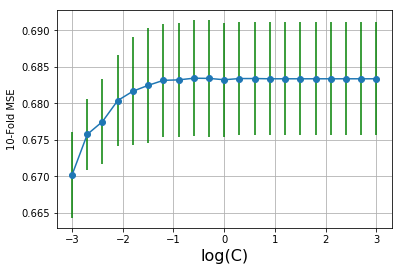

In [233]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

vectorC = np.logspace(-3,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'),#penalizar los errores de la clase minoritaria de distinta manera
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

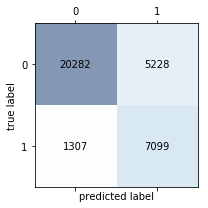

ACC:  0.8073180799622597
SEN:  0.844515822031882
ESP:  0.7950607604860839
PPV:  0.5758903220572726
FSC:  0.6848020064631264


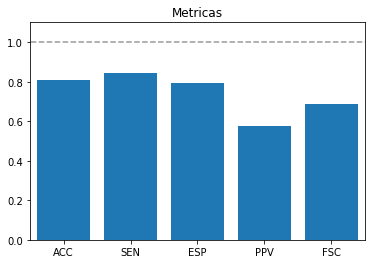

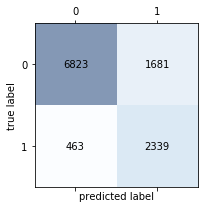

ACC:  0.8103661772510171
SEN:  0.8347608850820842
ESP:  0.8023283160865475
PPV:  0.5818407960199005
FSC:  0.6857226619759601


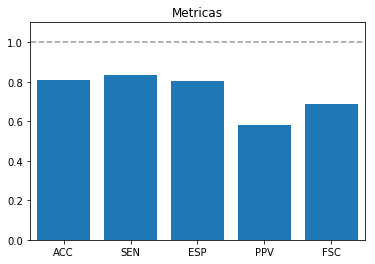

In [234]:
from sklearn.metrics import confusion_matrix

Copt = grid.best_params_['C']

lr = LogisticRegression(random_state=0, C = Copt, class_weight='balanced').fit(Xs_train,y_train)
y_pred_train = lr.predict(Xs_train)
y_pred = lr.predict(Xs_test)


confmat_train  = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(confmat_train)
calcula_metricas(confmat_train)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

El umbral se muestra en 0.5


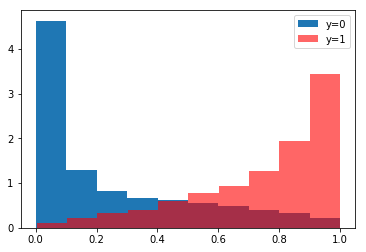

Existe mucho solapamiento entre clases


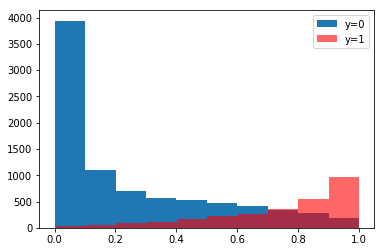

In [235]:
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
print('El umbral se muestra en 0.5')
plt.hist(y_prob[idx_0], normed = 1, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()
print('Existe mucho solapamiento entre clases')
plt.hist(y_prob[idx_0], normed = 0, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 0, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

Dado que tenemos un alto solapamiento entre clases obtenemos un nivel de precisión bajísimo

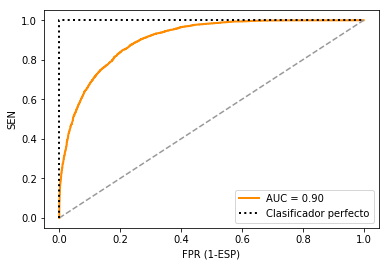

In [236]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

La curva ROC es igual al caso en que no se incluye el parámetro classweight por lo que no tenemos un mejor clasificador sino que sólo hemos logrado trasladar el umbral, aumentar la sensibilidad y reducir la precisión. Adicionalmente reducimos el accuracy de 0.82 a 0.77

## 3.2 Árboles de decisión

Entrenamos ahora un árbol de decisión. Otra ventaja adicional de los árboles es que por su construcción hace frente al desbalanceo de las clases.


In [237]:
from sklearn.tree import DecisionTreeClassifier
#no hace falta usar un class_weight, porque los tree decision ya toman en cuenta el balanceo
maxDepth = range(1,30)
param_grid = {'max_depth': maxDepth }

grid = GridSearchCV(DecisionTreeClassifier(random_state=0),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.660
best parameters: {'max_depth': 9}


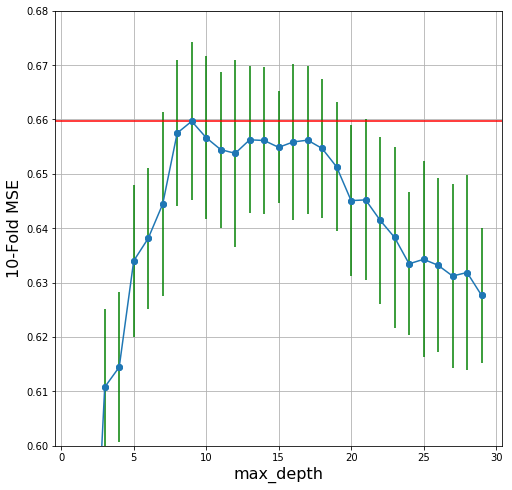

In [238]:

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']

plt.figure(figsize=(8,8))
plt.plot(maxDepth,scores,'-o')
plt.errorbar(maxDepth,scores,yerr=std_scores, fmt='o',ecolor='g')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE',fontsize=16)
plt.axhline(y=grid.best_score_, color='r', linestyle='-',label=grid.best_score_)
#plt.axvline(x=grid.best_params_['max_depth'], color='r')
plt.ylim((0.6, 0.68))
plt.grid()
plt.show()



El valor de profundidad óptimo es 14 pero observando la desviación podría coger incluso un valor de 6. Con una profundidad de 14 el modelo sobreajusta como se puede ver en el siguiente cuadro (ej, 0.88 vs 0.84 en accuracy) por lo que calculo más abajo las métricas con una profundidad de 6 reduciendo en gran medida el sobreajuste (ej: 0.8512 vs 0.8510 en accuracy).
A continuación grafico el árbol con profundidad de 6 y también incluyo la curva ROC con una profundidad de 6 y un área de 0.89 (con una profundidad de 14 era peor con 0.87)

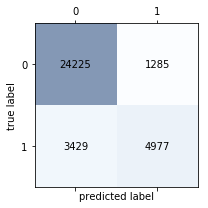

ACC:  0.861009553013327
SEN:  0.5920770877944326
ESP:  0.9496275970207761
PPV:  0.7947939955285851
FSC:  0.6786201254431415


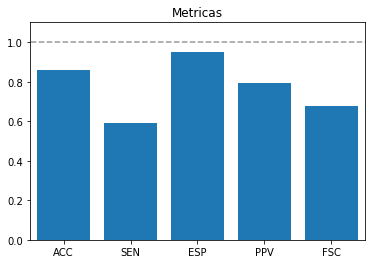

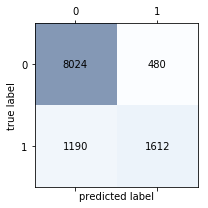

ACC:  0.8522908190341412
SEN:  0.5753033547466095
ESP:  0.9435559736594544
PPV:  0.7705544933078394
FSC:  0.6587658357172047


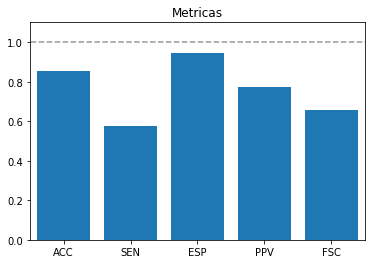

In [239]:
depthOpt = grid.best_params_['max_depth']

tree = DecisionTreeClassifier(random_state=0, max_depth= depthOpt).fit(Xs_train,y_train)
y_pred_train = tree.predict(Xs_train)
y_pred = tree.predict(Xs_test)

confmat_train  = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(confmat_train)
calcula_metricas(confmat_train)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

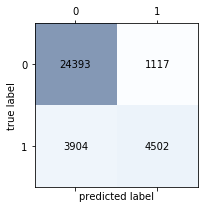

ACC:  0.8519577780398632
SEN:  0.535569831073043
ESP:  0.9562132497059976
PPV:  0.801210179747286
FSC:  0.6419964349376114


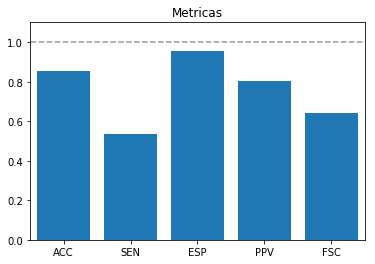

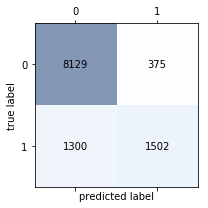

ACC:  0.8518485759773572
SEN:  0.53604568165596
ESP:  0.9559031044214488
PPV:  0.8002131060202451
FSC:  0.6420175251122034


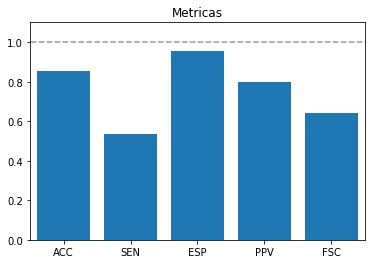

In [240]:
depthOpt = 6

tree = DecisionTreeClassifier(random_state=0, max_depth= depthOpt).fit(Xs_train,y_train)
y_pred_train = tree.predict(Xs_train)
y_pred = tree.predict(Xs_test)

confmat_train  = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(confmat_train)
calcula_metricas(confmat_train)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

<div class = "alert alert-success">
**Visualización del árbol de decisión entrenado para comprender las predicciones realizadas.
</div>

In [241]:
X[1:2,:]

array([[50., 13.,  1.,  0.,  0., 13.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.]])

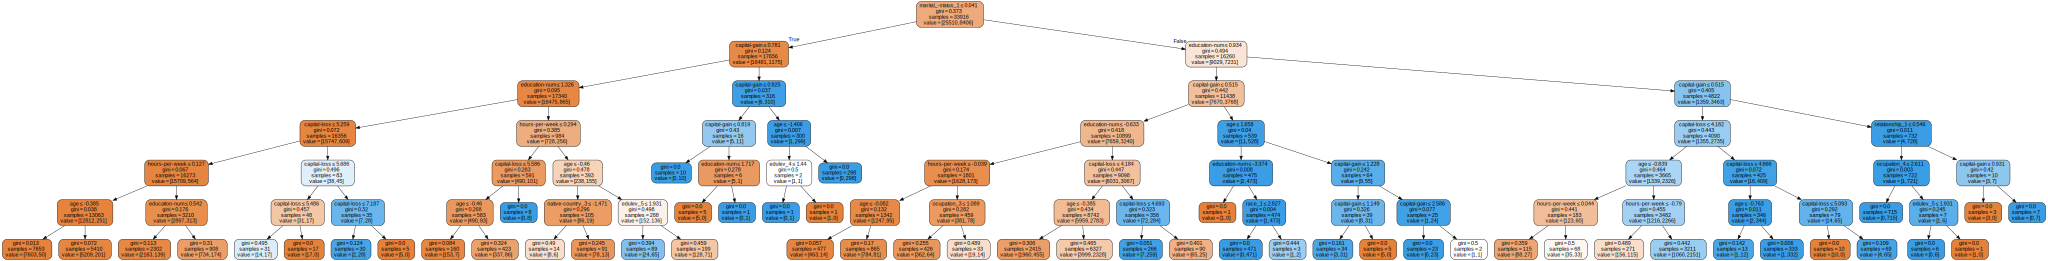

In [242]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=features,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 

graph

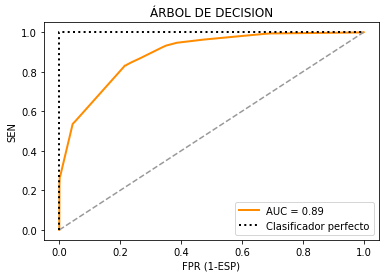

In [243]:
y_prob = tree.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.title('ÁRBOL DE DECISION')
plt.legend(loc="lower right")
plt.show()

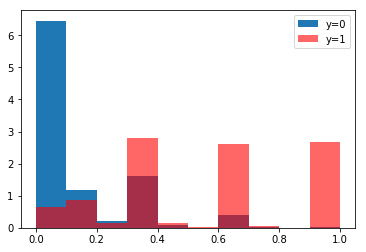

In [244]:
y_prob = tree.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], normed = 1, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

## 3.3 Random Forest

Comprobemos prestaciones para un algoritmo de Random Forest.


In [109]:
from sklearn.ensemble import RandomForestClassifier

# grid search
maxDepth   = range(1,50)
param_grid = {'max_depth': maxDepth, 'n_estimators':[200, 500, 1000]}

grid = GridSearchCV(RandomForestClassifier(random_state=0, max_features='sqrt', class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.706
best parameters: {'max_depth': 18, 'n_estimators': 500}


In [110]:
from joblib import dump, load
dump(grid, '1_randomforest_class.joblib')

['1_randomforest_class.joblib']

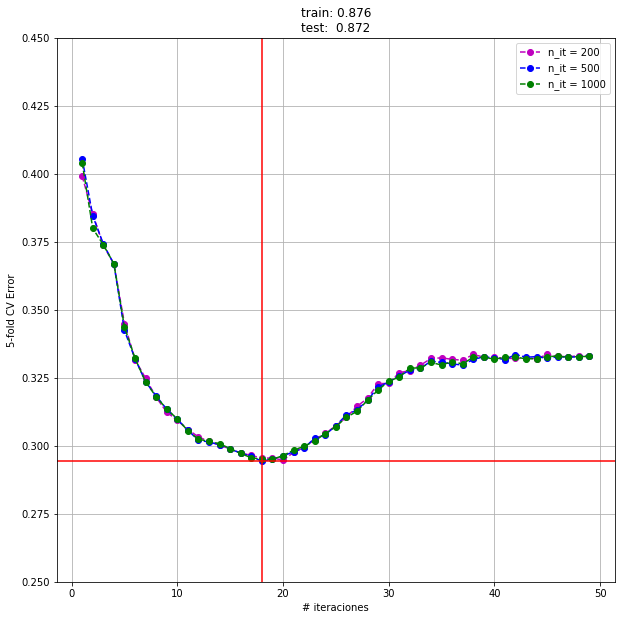

Zoom en la imagen:


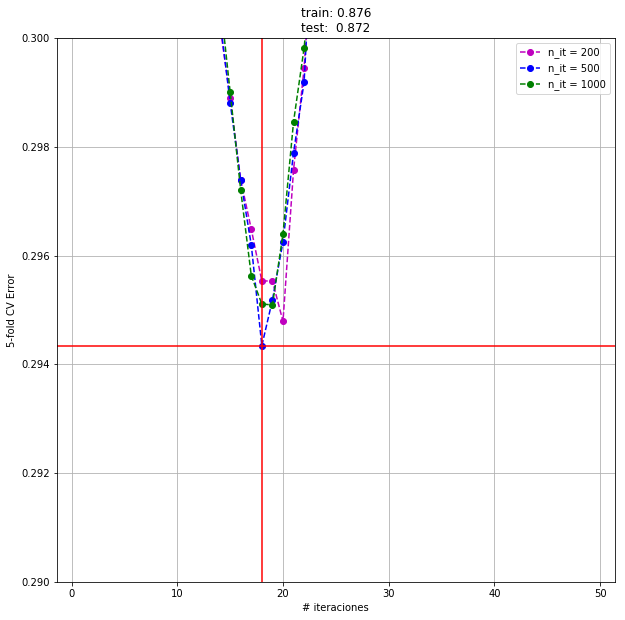

In [195]:
errors =1- grid.cv_results_['mean_test_score'].reshape(len(maxDepth),len(Niterations))
std_scores = grid.cv_results_['std_test_score'].reshape(len(maxDepth),len(Niterations))


colors = ['m','b','g']

def draw_lines(ylower,yupper):
    plt.figure(figsize=(10,10))
    for i,n_it in enumerate(Niterations):  
        plt.plot(maxDepth,errors[:,i],color=colors[i] , linestyle='--', marker='o',label='n_it = %g'%n_it  )
        #plt.errorbar(maxDepth,errors[:,i],yerr=std_scores[:,i], fmt='o',ecolor='g',color=colors[i], linestyle='--', marker='o',label='n_it = %g'%n_it)
    plt.legend()
    plt.xlabel('# iteraciones')
    plt.ylabel('5-fold CV Error')
    plt.title('train: %0.3f\ntest:  %0.3f'%(score_train,score_test))
    plt.axhline(y=1-grid.best_score_, color='r', linestyle='-',label=grid.best_score_)
    plt.axvline(x=grid.best_params_['max_depth'], color='r')
    plt.ylim((ylower,yupper))
    plt.grid()
    plt.show()
    
draw_lines(0.25, 0.45)
print('Zoom en la imagen:')
draw_lines(0.29,0.3)

### Muestro las 3 curvas con iteraciones de 200, 500 y 1000 y la cruz muestra el nivel de error más bajo 
### con su respectivo nivel de profundidad
### En el último gráfico hago un zoom para apreciar mejor la selecció del nivel de profundidad

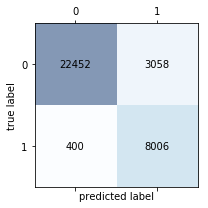

ACC:  0.8980422219601368
SEN:  0.9524149417083035
ESP:  0.8801254410035281
PPV:  0.7236080983369486
FSC:  0.8223934257832561


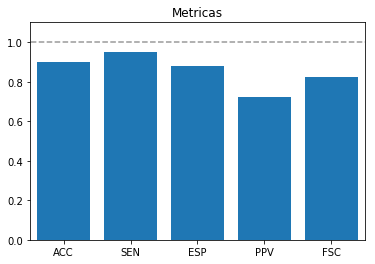

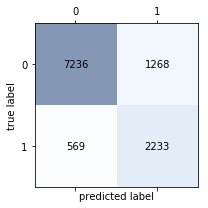

ACC:  0.8375199009375552
SEN:  0.7969307637401856
ESP:  0.8508936970837253
PPV:  0.6378177663524707
FSC:  0.7085514834205933


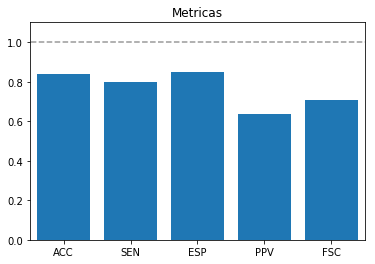

In [196]:
depthOpt = grid.best_params_['max_depth']
iterOpt = grid.best_params_['n_estimators']

rf = RandomForestClassifier(random_state=0,
                            max_depth=depthOpt,
                            n_estimators = iterOpt,
                            class_weight='balanced',
                            max_features='sqrt').fit(Xs_train,y_train)

y_pred_train = rf.predict(Xs_train)
y_pred_test  = rf.predict(Xs_test)

confmat_train  = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(confmat_train)
calcula_metricas(confmat_train)

confmat_test  = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

Como el modelo sobreajusta pruebo con el segundo mejor: 200 iteraciones, profundidad 18 pero sobreajusta en accuracy (0.92 vs 0.82) así que probando diferents valores a mano, el que menos sobreajuste tiene es un modelo con 200 iteraciones y profundidad de 15. Calculo métricas y grafico curva ROC. 

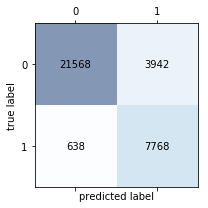

ACC:  0.8649604906238944
SEN:  0.9241018320247443
ESP:  0.8454723637789102
PPV:  0.6633646456020496
FSC:  0.7723205408629947


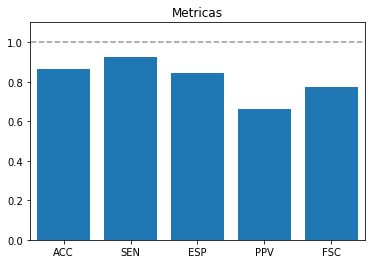

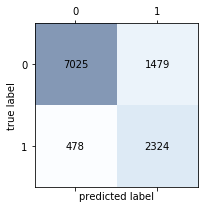

ACC:  0.8269060675747391
SEN:  0.8294075660242684
ESP:  0.8260818438381938
PPV:  0.6110965027609782
FSC:  0.7037093111279332


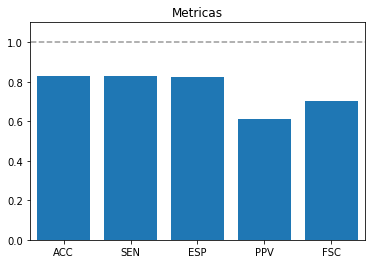

In [204]:
#depthOpt = grid.best_params_['max_depth']
#iterOpt = grid.best_params_['n_estimators']

rf = RandomForestClassifier(random_state=0,
                            max_depth=15,
                            n_estimators = 200,
                            class_weight='balanced',
                            max_features='sqrt').fit(Xs_train,y_train)

y_pred_train = rf.predict(Xs_train)
y_pred_test  = rf.predict(Xs_test)

confmat_train  = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(confmat_train)
calcula_metricas(confmat_train)

confmat_test  = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

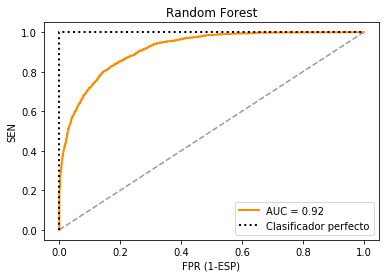

In [205]:
y_prob = rf.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.title('Random Forest')
plt.legend(loc="lower right")
plt.show()

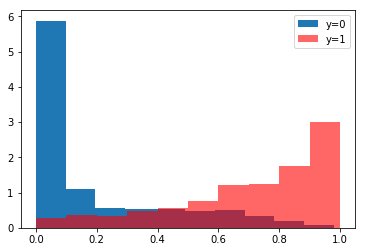

In [198]:
y_prob = rf.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], normed = 1, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

## 3.5 Boosted trees

Comprobemos prestaciones para un algoritmo de Boosted trees.



El entrenamiento del algoritmo de boosting requiere fijar tres parámetros libres:

- Número de iteraciones
- Tasa de aprendizaje ($\alpha$)
- Complejidad del árbol: *max_depth*

Se podría hacer una búsqueda sobre los tres parámetros conjuntamente mediante GridSearchCV, sin embargo, es muy costoso computacionalmente, con lo que es más sencillo aplicar una optimización secuencial: se prueban distintos valores de los parámetros libres, se fijan los óptimos y se busca sobre el resto.

In [39]:
#####

from sklearn.ensemble import GradientBoostingClassifier

Niterations = [25,50,75,100,125,150,175,200,300,1000,5000,10000]
learningRate = [0.5,0.1,0.05,0.01]
maxDepth   = range(1,6)

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate, 'max_depth':maxDepth }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0), param_grid=param_grid, cv = 5)
grid.fit(Xs_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 300, 1000, 5000, 10000], 'learning_rate': [0.5, 0.1, 0.05, 0.01], 'max_depth': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
from joblib import dump, load
dump(grid, '1_bt_class.joblib') 

['1_bt_class.joblib']

In [58]:
#from joblib import dump, load
#grid= load('1_bt_class.joblib') 

best mean cross-validation score: 0.870
best parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 5000}


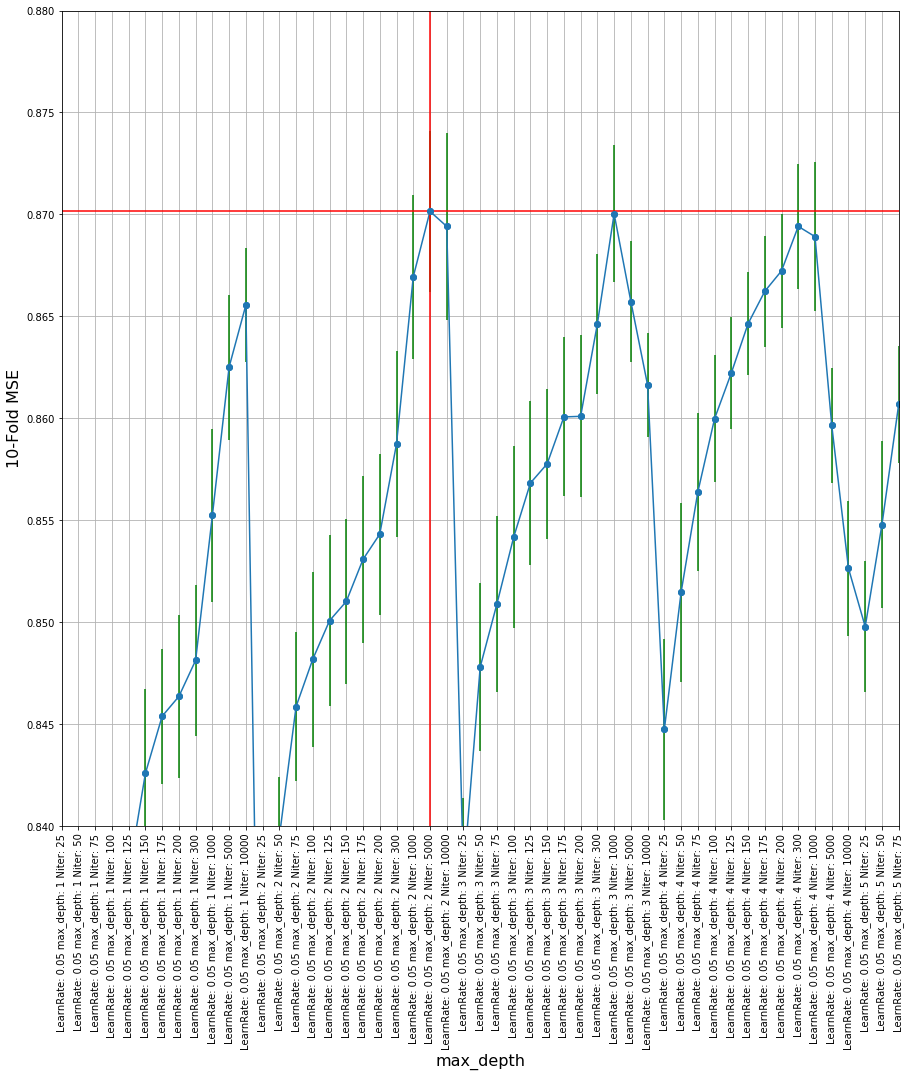

In [41]:

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

from itertools import product
axis_x = ['LearnRate: '+str(a)+ ' max_depth: '+str(b) +' Niter: '+str(c) for a, b, c in product(learningRate, maxDepth, Niterations,)]

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']

plt.figure(figsize=(15,15))
plt.plot(axis_x,scores,'-o')
plt.errorbar(axis_x,scores,yerr=std_scores, fmt='o',ecolor='g')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE',fontsize=16)
plt.xticks(rotation=90)
plt.axhline(y=grid.best_score_, color='r', linestyle='-',label=grid.best_score_)
plt.axvline(x=list(scores).index(grid.best_score_), color='r')
plt.ylim((0.84, 0.88))
plt.xlim((120, 170))
plt.grid()
plt.show()


###Parecía buena idea ver en un gráfico como varían los scores cuando varían cada uno de los 3 parámetros.
##La cruz roja muestra la combinación óptima de acuerdo con el algoritmo de validación cruzada

In [61]:
# calculamos métricas globales
bt = GradientBoostingClassifier(random_state=0, max_depth=2,learning_rate= 0.05, n_estimators= 5000)
bt.fit(Xs_train,y_train)
score_train=bt.score(Xs_train,y_train)
score_test=bt.score(Xs_test,y_test)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(maxDepth),len(Niterations))

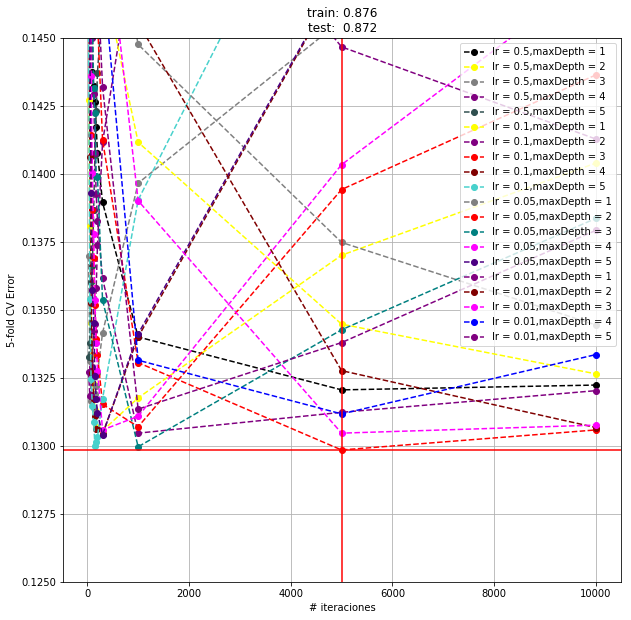

Zoom en la imagen:


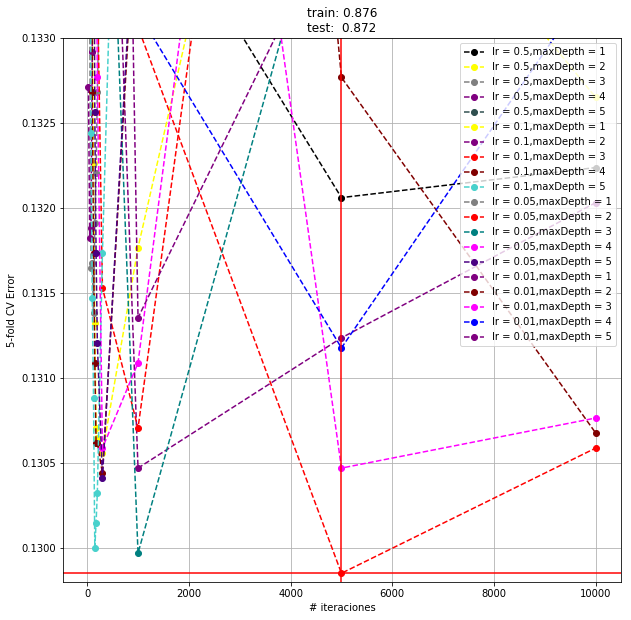

In [100]:

colors = [(0,0,0),	(255,255,0),	(128,128,128),	(128,0,128),	(47,79,79),
(255,0,0),	(0,255,255),	(128,0,0),	(0,128,128),	(72,209,204),
(0,255,0),	(255,0,255),	(128,128,0),	(0,0,128),	(75,0,130),
(0,0,255),	(192,192,192),	(0,128,0),	(50,205,50),	(128,0,128)]

def draw_lines(ylower,yupper):
    plt.figure(figsize=(10,10))
    for i,lr in enumerate(learningRate):  
        for j in range(0,error[i].shape[0]):
            plt.plot(Niterations,error[i,j,:],color=[x/255.0 for x in colors[(i+1)*(j+1)-1]] , linestyle='--', marker='o',label='lr = %g,maxDepth = %g'%(lr,j+1)  )

    plt.legend()
    plt.xlabel('# iteraciones')
    plt.ylabel('5-fold CV Error')
    plt.title('train: %0.3f\ntest:  %0.3f'%(score_train,score_test))
    plt.axhline(y=1-grid.best_score_, color='r', linestyle='-',label=grid.best_score_)
    plt.axvline(x=grid.best_params_['n_estimators'], color='r')
    plt.ylim((ylower,yupper))
    plt.grid()
    plt.show()
    
draw_lines(0.125, 0.145)
print('Zoom en la imagen:')
draw_lines(0.1298,0.133)

Mirando el gráfico, la combinación óptima estaría en 5000 iteraciones con (lr, maxDepth)=(0.05,2), sin embargo no alcanza un mínimo por lo que el algoritmo no está aprendiendo correctamente. Sin repetir el ejercicio con más iteraciones, es más conveniente tomar la curva  (lr, maxDepth)=(0.01,2) que alcanza el mínimo en 10000 iteraciones aunque tengamos un error mayor que la combinación propuesta por el algoritmo de validación cruzada. 

En la combinación elegida se ve que el algoritmo aprende más lentamente y posiblemente con más iteraciones sea más notoria la convergencia (o divergencia si tampoco son los parámetros más eficientes.

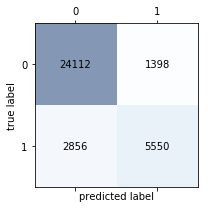

ACC:  0.8745724731690058
SEN:  0.6602426837972877
ESP:  0.9451979615836926
PPV:  0.7987910189982729
FSC:  0.7229386479093396


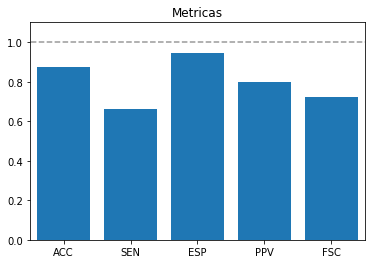

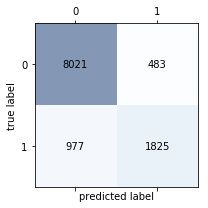

ACC:  0.8708650274190696
SEN:  0.6513204853675946
ESP:  0.9432031984948259
PPV:  0.7907279029462738
FSC:  0.7142857142857143


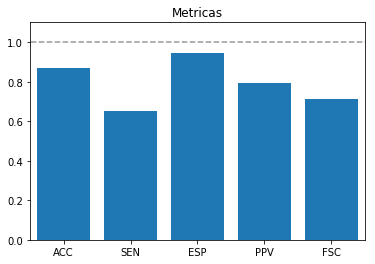

In [103]:
#aplicando la curva (lr, maxDepth)=(0.01,2)
bt = GradientBoostingClassifier(random_state=0, max_depth=2,learning_rate= 0.01, n_estimators= 10000).fit(Xs_train,y_train)

y_pred_train = bt.predict(Xs_train)
y_pred_test  = bt.predict(Xs_test)

confmat_train  = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(confmat_train)
calcula_metricas(confmat_train)

confmat_test  = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

En las métricas podemos comprobar que no hay sobreajuste

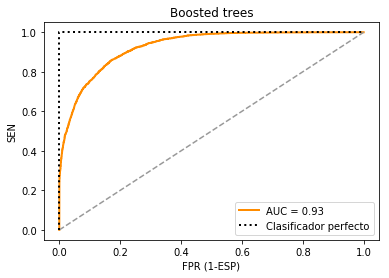

In [106]:
y_prob = bt.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.title('Boosted trees')
plt.legend(loc="lower right")
plt.show()

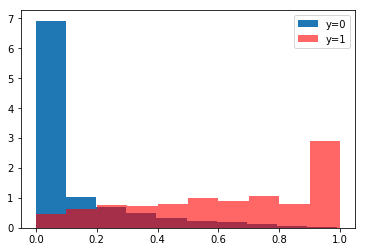

In [46]:
y_prob = bt.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], normed = 1, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

## 3.5 SVM

Comprobemos prestaciones para un algoritmo de SVM.

<div class = "alert alert-success">
**EJERCICIO**: Entrena un algoritmo de SVM y calcula las métricas obtenidas en el conjunto de test.
</div>

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# paso 1
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


# copiamos del 3.3
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

print('Datos train: ', X_train_s.shape)
print('Datos test:  ', X_test_s.shape)

Datos train:  (33916, 13)
Datos test:   (11306, 13)


In [56]:
from sklearn.svm import SVC

# Paso 2: búsqueda de parámetros libres

vectorC = np.logspace(-1, 2, 20)
vectorG = np.logspace(-4, 0, 20)

param_grid = {'C': vectorC, 'gamma':vectorG}

grid = GridSearchCV(SVC(kernel = 'rbf'), scoring = 'accuracy', param_grid = param_grid, cv = 5)
grid.fit(X_train_s, y_train)


print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.845
best parameters: {'C': 3.79269019073225, 'gamma': 0.05455594781168514}


In [49]:
from joblib import dump, load
dump(grid, '1_svm_class.joblib') 

['1_svm_class.joblib']

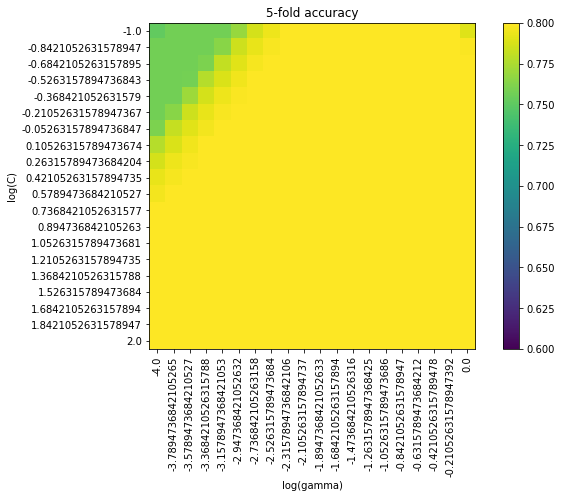

In [54]:
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.8)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

In [55]:
# Paso 3
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

print('C: ', Copt)
print('gamma: ', Gopt)

svm = SVC(kernel='rbf',gamma = Gopt, C = Copt).fit(X_train_s,y_train)

print('Acc (TRAIN): %0.2f'%svm.score(X_train_s,y_train))
print('Acc (TEST):  %0.2f'%svm.score(X_test_s,y_test))

C:  3.79269019073225
gamma:  0.05455594781168514
Acc (TRAIN): 0.85
Acc (TEST):  0.85


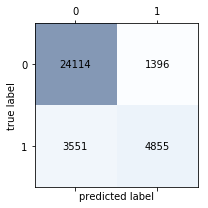

ACC:  0.8541396391083854
SEN:  0.5775636450154652
ESP:  0.9452763622108977
PPV:  0.7766757318828987
FSC:  0.6624820904687181


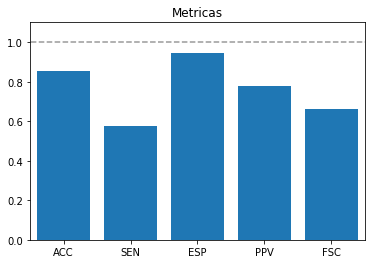

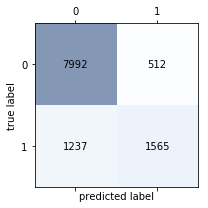

ACC:  0.8453033787369538
SEN:  0.5585296216987866
ESP:  0.9397930385700847
PPV:  0.7534906114588349
FSC:  0.6415249026439844


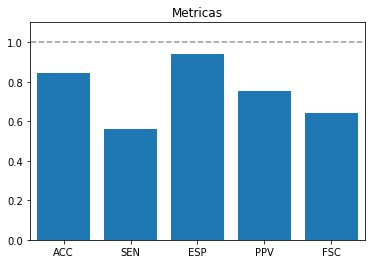

In [104]:
y_pred_train = svm.predict(Xs_train)
y_pred_test  = svm.predict(Xs_test)

confmat_train  = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(confmat_train)
calcula_metricas(confmat_train)

confmat_test  = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

In [ ]:
#Como el valor probability lo dejé en False (tardaría incluso más) no puedo calcular la curva ROC.
#De todos modos, se trata de una aproximación por lo que habría que analizarlo con cuidado!
y_prob = svm.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], normed = 1, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

Aplicando un kernel rbf con valores de c y gamma entre -1 y 2 y -4 y 0 respectivamente, he conseguido un modelo sin overfitting pero con un porcentaje de accuracy ligeramente más bajo que los modelos anteriores. Lo correcto sería calcular lo que pasa con un rango más amplio de valores de c y gamma (mirando el gráfico los valores estarían por encima de 2 para c y por encima de 0 para gamma) pero lastimosamente el algoritmo tarda casi 2 días en ejecutarse y no tendré tiempo para entregar los nuevos resultados con la práctica.

Conclusión: Boosted tree es algoritmo con el que conseguí mejores métricas (mayor área bajo la curva, accuracy, sensitivity, etc.) y además no tiene overfitting. Posiblemente con más iteraciones se pueda confirmar que he escogido la mejor combinación de lr y maxDepth. Adicionalmente, iterando svm con otros valores de c y gamma podría tener un modelo con mejores prestaciones incluso que boosted tree.